# Notes

Due to the randomness of some of the processes, the final results may be slightly different.

# Load Modules

In [1]:
import os

import numpy as np
import pandas as pd
from more_itertools import flatten

In [13]:
from scipy.spatial import distance

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

In [3]:
from scipy.linalg import cholesky, eigh, svd

In [4]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Download Data

In [ ]:
%%bash

# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/counts.h5ad
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/cell_labels.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse1sample1.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse1sample2.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse1sample3.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse1sample4.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse1sample5.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse1sample6.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse2sample1.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse2sample2.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse2sample3.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse2sample4.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse2sample5.csv
# wget https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/segmented_cells_mouse2sample6.csv

# Load Data

In [114]:
adata = ad.read_h5ad('counts.h5ad')

In [115]:
cell_label_df = pd.read_csv('cell_labels.csv', index_col=0)

# calculate cell center

In [116]:
def calculate_spatial(segmentation_file: str) -> pd.DataFrame:
    
    def cal_pos(row) -> float:
        return pd.Series([np.nanmedian(np.array(list(flatten([ [np.nan] if isinstance(element, float) else [float(value) for value in element.strip("'").split(', ')] for element in row[X_columns].values.tolist()])))),
                np.nanmedian(np.array(list(flatten([ [np.nan] if isinstance(element, float) else [float(value) for value in element.strip("'").split(', ')] for element in row[Y_columns].values.tolist()]))))], index = ['x', 'y'])
    
    segmentation_df = pd.read_csv(segmentation_file, index_col=0)
    X_columns = [x for x in segmentation_df.columns if 'boundaryX' in x]
    Y_columns = [x for x in segmentation_df.columns if 'boundaryY' in x]
    
    spatial_df = segmentation_df.apply(cal_pos, axis=1, result_type='expand')
    
    return spatial_df
    

In [117]:
segmentation_files = [f for f in os.listdir() if f.startswith('segmented_cells_mouse')]

spatial_df = pd.DataFrame()

for segmentation_file in segmentation_files:
    spatial_df_ = calculate_spatial(segmentation_file)
    spatial_df = pd.concat([spatial_df, spatial_df_])

In [118]:
cell_label_df = cell_label_df.join(spatial_df)

In [119]:
cell_label_df.head()

,sample_id,slice_id,class_label,subclass,label,x,y
10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1,4738.402723,3075.604074
100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo,-3965.470904,1451.943297
100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC,805.848948,1215.458623
100007228202835962319771548915451072492,mouse1_sample2,mouse1_slice71,Other,Endo,Endo,1347.655448,-3589.803355
100009332472089331948140672873134747603,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3,-3584.216904,-1883.214455


# Cortial depth

In [120]:
samples = cell_label_df['slice_id'].unique()

In [121]:
cortical_depth_df = pd.DataFrame()

for sample in samples:
    sample_df = cell_label_df[cell_label_df['slice_id'] == sample]
    distance_matrix = distance.cdist(sample_df[['x','y']].values, sample_df[['x','y']].values, 'euclidean')
    sample_df['cortical_depth'] = np.min(distance_matrix[:,sample_df['subclass'] == 'VLMC'],axis=1)
    cortical_depth_df = pd.concat([cortical_depth_df, sample_df[['cortical_depth']]])

/tmp/ipykernel_253593/1901163736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['cortical_depth'] = np.min(distance_matrix[:,sample_df['subclass'] == 'VLMC'],axis=1)
/tmp/ipykernel_253593/1901163736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['cortical_depth'] = np.min(distance_matrix[:,sample_df['subclass'] == 'VLMC'],axis=1)
/tmp/ipykernel_253593/1901163736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [122]:
cortical_depth_df.head()

,cortical_depth
10000143038275111136124942858811168393,888.114748
100091152035772192874698518269494521268,519.891790
100318785722691998123111916762029843183,161.722279
100341059438931731510635049259352883335,593.476063
101059342090754465645773829438399819266,200.021444


In [123]:
meta_df = cell_label_df.join(cortical_depth_df)

# processing using scanpy

## load meta data

In [124]:
adata.obs = adata.obs.join(meta_df)

## Normalization

In [125]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [126]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

In [127]:
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

In [128]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="slice_id")

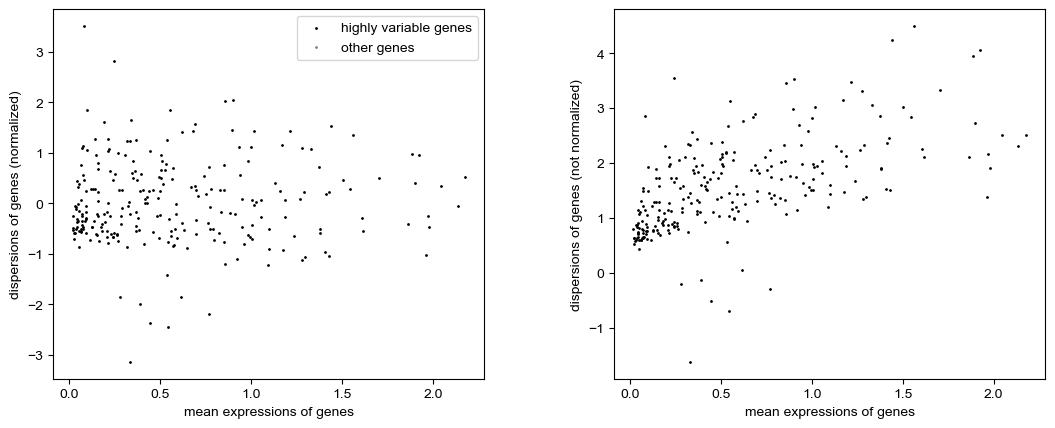

In [129]:
sc.pl.highly_variable_genes(adata)

## Dimensionality reduction

In [130]:
sc.tl.pca(adata)

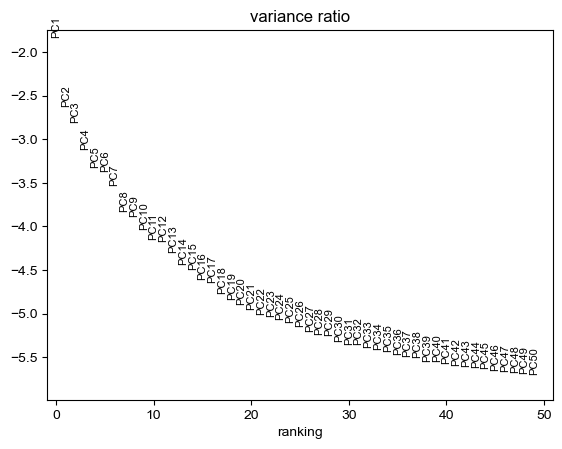

In [131]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


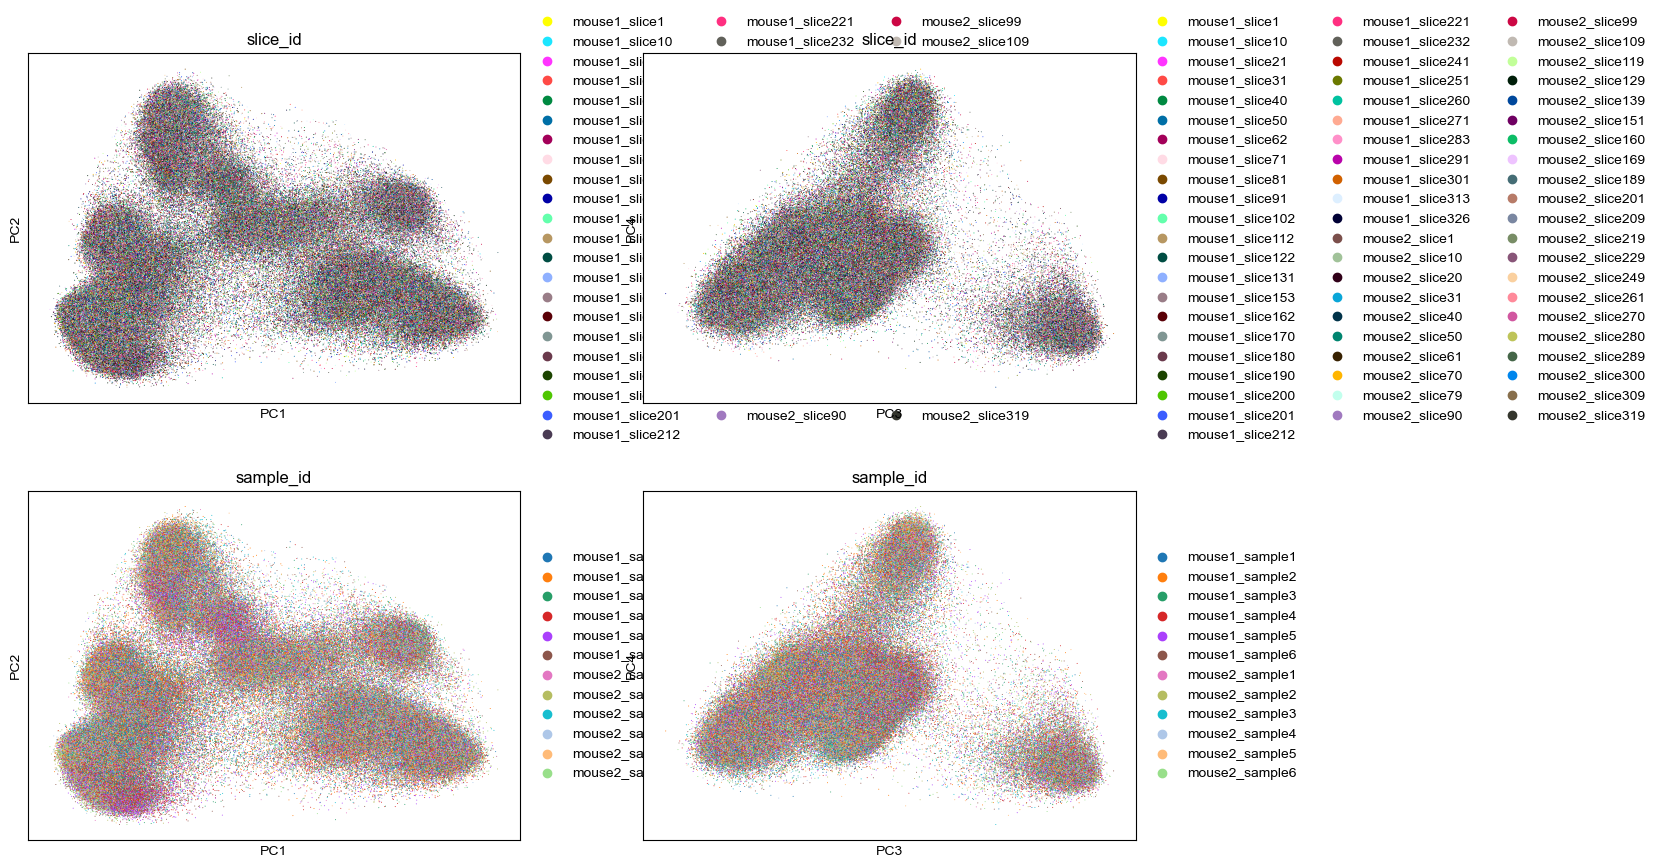

In [132]:
sc.pl.pca(
    adata,
    color=["slice_id", "slice_id","sample_id","sample_id"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## harmony

In [133]:
adata.obs.head()

,sample_id,slice_id,class_label,subclass,label,x,y,cortical_depth
index,,,,,,,,
10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1,4738.402723,3075.604074,888.114748
100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo,-3965.470904,1451.943297,287.558864
100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC,805.848948,1215.458623,22.943763
100007228202835962319771548915451072492,mouse1_sample2,mouse1_slice71,Other,Endo,Endo,1347.655448,-3589.803355,197.945973
100009332472089331948140672873134747603,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3,-3584.216904,-1883.214455,308.178627


In [134]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, 'slice_id')

2024-08-05 12:22:04,275 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-05 12:23:17,987 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-05 12:23:19,398 - harmonypy - INFO - Iteration 1 of 10
2024-08-05 12:26:37,940 - harmonypy - INFO - Iteration 2 of 10
2024-08-05 12:29:44,216 - harmonypy - INFO - Iteration 3 of 10
2024-08-05 12:32:56,599 - harmonypy - INFO - Iteration 4 of 10
2024-08-05 12:35:51,228 - harmonypy - INFO - Iteration 5 of 10
2024-08-05 12:38:46,190 - harmonypy - INFO - Iteration 6 of 10
2024-08-05 12:41:50,610 - harmonypy - INFO - Iteration 7 of 10
2024-08-05 12:43:12,644 - harmonypy - INFO - Iteration 8 of 10
2024-08-05 12:44:28,293 - harmonypy - INFO - Converged after 8 iterations


/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


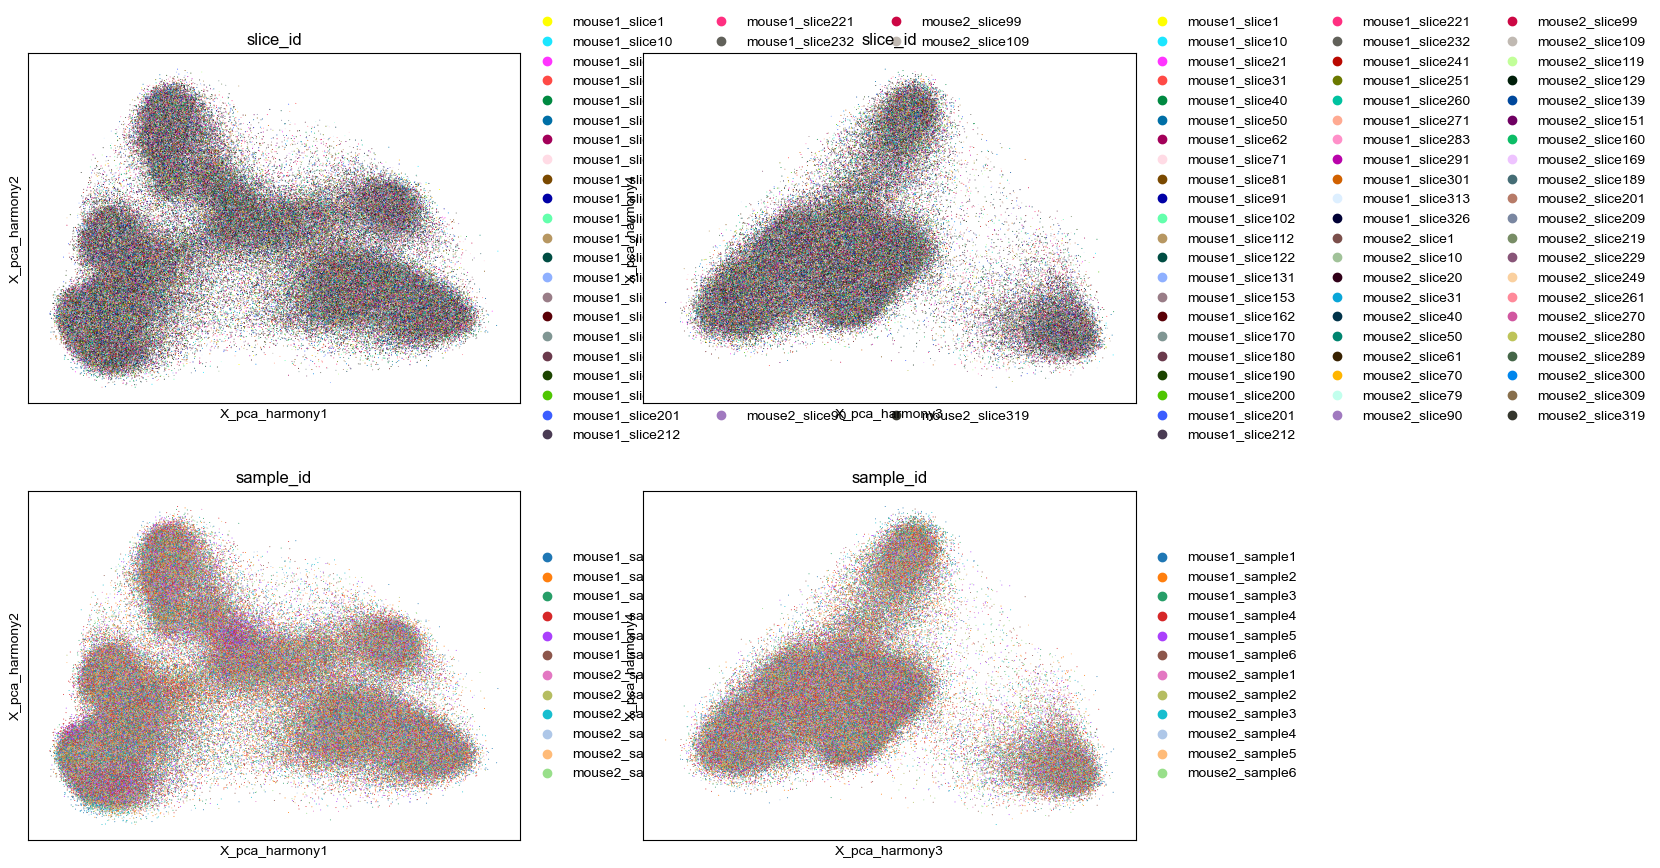

In [135]:
sc.pl.embedding(
    adata,
    "X_pca_harmony",
    color=["slice_id", "slice_id","sample_id","sample_id"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## UMAP

### neighbors

In [136]:
sc.pp.neighbors(adata,use_rep="X_pca_harmony",n_neighbors=20,key_added="PCA_harmony_neighbors")

### UMAP

In [137]:
sc.tl.umap(adata, neighbors_key="PCA_harmony_neighbors")

/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


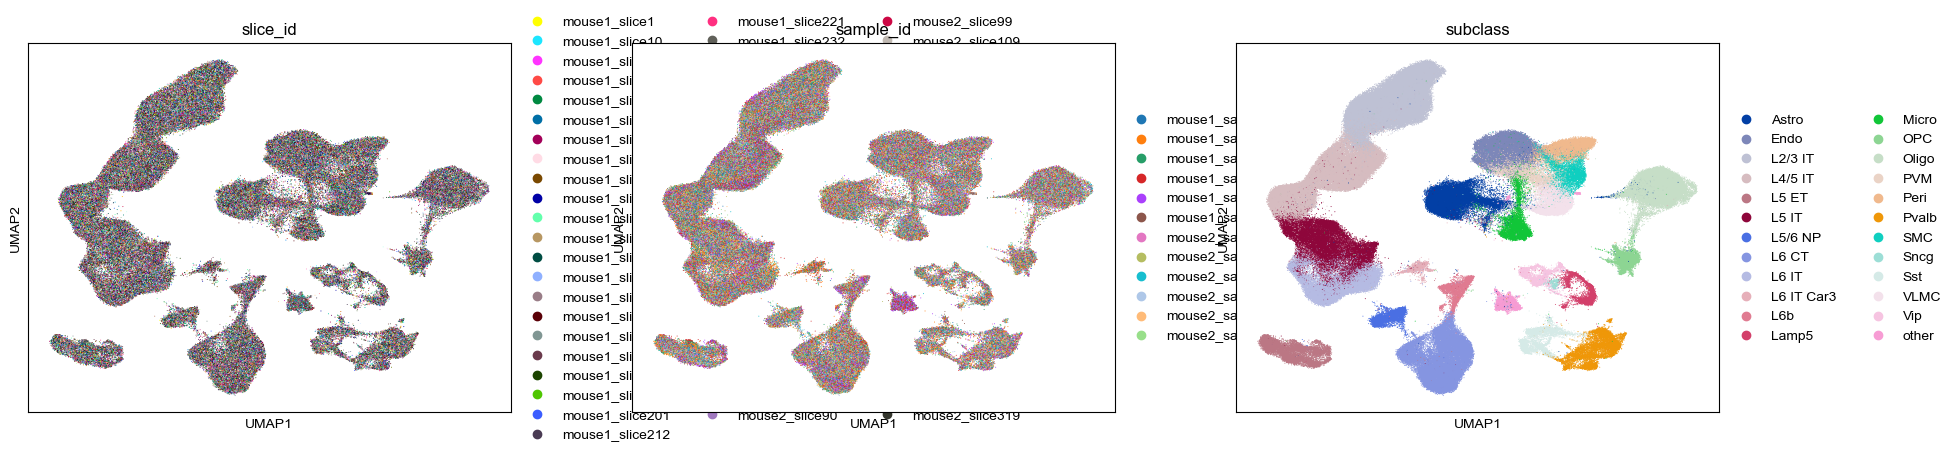

In [138]:
sc.pl.umap(
    adata,
    color=["slice_id", "sample_id", "subclass"],
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## clustering

In [94]:
# we use extreme resolution 10 and 30 here to test the robustness of ONTraC
for res in [10.0, 30.0]:
    sc.tl.leiden(
        adata, neighbors_key='PCA_harmony_neighbors', key_added=f"leiden_res_{res:4.2f}", resolution=res
    )

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [156]:
# adata.obs.to_csv('raw_meta.csv.gz')

# Generate input for ONTraC and other methods

read the preprocessed meta data in case of different by randomness

In [157]:
adata.obs = pd.read_csv('raw_meta.csv.gz', index_col=0)

## Generate input files for ONTraC

### meta data

In [158]:
adata.obs.head()

,sample_id,slice_id,class_label,subclass,label,x,y,cortical_depth,leiden_res_10.00,leiden_res_30.00
index,,,,,,,,,,
10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1,4738.402723,3075.604074,888.114748,0,117
100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo,-3965.470904,1451.943297,287.558864,36,263
100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC,805.848948,1215.458623,22.943763,46,18
100007228202835962319771548915451072492,mouse1_sample2,mouse1_slice71,Other,Endo,Endo,1347.655448,-3589.803355,197.945973,56,215
100009332472089331948140672873134747603,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3,-3584.216904,-1883.214455,308.178627,65,130


#### 24-subclass

In [161]:
ONTraC_input_meta_df = adata.obs[adata.obs['slice_id'] == 'mouse1_slice221'][['slice_id', 'subclass', 'x', 'y']]
ONTraC_input_meta_df.columns = ['Sample', 'Cell_Type', 'x', 'y']
ONTraC_input_meta_df.to_csv('merfish_mouse1_slice221_24_subclass_meta.csv', index=True, index_label='Cell_ID')

#### 99-label

In [162]:
ONTraC_input_meta_df = adata.obs[adata.obs['slice_id'] == 'mouse1_slice221'][['slice_id', 'label', 'x', 'y']]
ONTraC_input_meta_df.columns = ['Sample', 'Cell_Type', 'x', 'y']
ONTraC_input_meta_df.to_csv('merfish_mouse1_slice221_99_label_meta.csv', index=True, index_label='Cell_ID')

#### 126-cluster

In [164]:
ONTraC_input_meta_df = adata.obs[adata.obs['slice_id'] == 'mouse1_slice221'][['slice_id', 'leiden_res_10.00', 'x', 'y']]
ONTraC_input_meta_df.columns = ['Sample', 'Cell_Type', 'x', 'y']
ONTraC_input_meta_df.to_csv('merfish_mouse1_slice221_126_cluster_meta.csv', index=True, index_label='Cell_ID')

#### 361-cluster

In [165]:
ONTraC_input_meta_df = adata.obs[adata.obs['slice_id'] == 'mouse1_slice221'][['slice_id', 'leiden_res_30.00', 'x', 'y']]
ONTraC_input_meta_df.columns = ['Sample', 'Cell_Type', 'x', 'y']
ONTraC_input_meta_df.to_csv('merfish_mouse1_slice221_361_cluster_meta.csv', index=True, index_label='Cell_ID')

### pre-computed embedding

Notes: pre-computed embeddings also provided here, as difference introduced by randomness exists here

In [167]:
embedding_array = adata.obsm['X_pca_harmony'][adata.obs['slice_id'] == 'mouse1_slice221',:]
embedding_df = pd.DataFrame(embedding_array,
                            index = adata.obs[adata.obs['slice_id'] == 'mouse1_slice221'].index,
                            columns = [f'Embedding_{i+1}' for i in range(embedding_array.shape[1])])
embedding_df.to_csv('merfish_mouse1_slice221_embedding.csv')

array([[ 3.0550957 , -0.44283974,  1.5046175 , ..., -0.6553277 ,
         0.5024853 , -1.1110269 ],
       [ 6.9509377 , -2.6372862 , -4.547944  , ...,  0.20131058,
         0.41476342,  0.14027637],
       [ 4.670484  , -0.92198175, -2.6187994 , ..., -0.3595377 ,
        -0.14749876,  0.7508816 ],
       ...,
       [-0.5459575 , -2.2971535 ,  0.84453857, ..., -0.5467943 ,
         0.02958409,  0.6092881 ],
       [-0.6446445 ,  4.058688  , -0.32934368, ...,  0.4930467 ,
         0.6935002 , -1.1638943 ],
       [-4.2520757 , -2.1861887 ,  0.5732216 , ..., -0.11108056,
        -0.5223774 ,  0.08008303]], dtype=float32)

### expression data

In [193]:
exp_array = adata.layers['counts'][adata.obs['slice_id'] == 'mouse1_slice221',:]
exp_df = pd.DataFrame(exp_array,
                      index = adata.obs[adata.obs['slice_id'] == 'mouse1_slice221'].index,
                      columns = adata.var.index.tolist())
exp_df.to_csv('mouse1_slice221_counts.csv')